In [3]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [ ]:
# Could not read sqlite file so the following is to help me understand the data

In [7]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns: 
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns: 
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [ ]:
# Start date of trip - 2016-12-16
# End date of trip - 2016-12-31

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [22]:
# Calculate the date 1 year ago from the last data point in the database

# Last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# # last_date = 2017-08-23

# 1 year data from last data point
a_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
a_year_ago

datetime.date(2016, 8, 23)

In [111]:
# Perform a query to retrieve the data and precipitation scores
scores = session.query(Measurement.date, func.sum(Measurement.prcp)).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= a_year_ago).\
        group_by(Measurement.date).\
            order_by(Measurement.date).all()

# scores

In [112]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
scores_df = pd.DataFrame(scores, columns = ['Date', 'Precipitation']).set_index(['Date']).sort_index(ascending = True)

scores_df.head()


,Precipitation
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


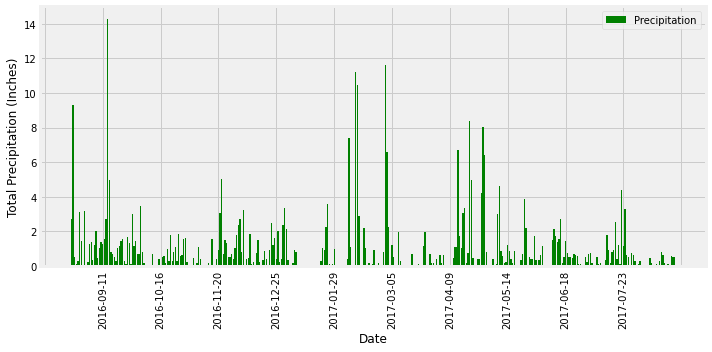

In [146]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=[10,5])
ax.bar(scores_df.index.values, scores_df['Precipitation'], color= "green" , label = 'Precipitation')

# importing additional packages
import matplotlib.dates as mdates


plt.ylim(0, 15)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
plt.xticks(rotation='vertical')

plt.xlabel('Date')
plt.ylabel('Total Precipitation (Inches)')
# plt.title()
ax.legend()
plt.tight_layout()
plt.show()

In [118]:
# Use Pandas to calcualte the summary statistics for the precipitation data
scores_df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


### QUERY - above count results should be 365 days????

# Station Analysis

In [105]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
station_count

9

In [107]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).\
            all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [119]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

stats_most_active = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

stats_most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

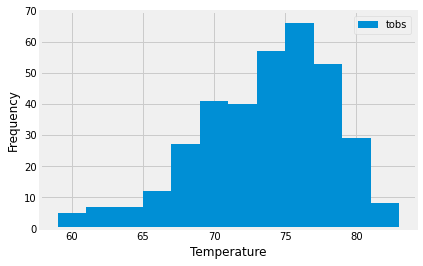

In [154]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# CHECK - whether station with the highest number of temp observation is still the same as USC00519281. The       instruction for this bit is a bit vague.....

highest_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).\
                all()
# highest_tobs
# CHECK!

# Last 12 months of tobs
most_active_station = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= a_year_ago).\
        group_by(Measurement.date).\
            order_by(Measurement.date).all()
# most_active_station

waihee_df = pd.DataFrame(most_active_station, columns = ['Station_ID', 'Temp_Obs']).set_index(['Station_ID'])
# waihee_df.head()

hist = plt.hist(waihee_df['Temp_Obs'], bins=12, label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
# plt.xlim(55, 90)
plt.ylim(0, 70)
plt.show()

## Bonus Challenge Assignment

In [155]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [158]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
